In [1]:
%tensorflow_version 2.x

import tensorflow as tf
print("tf version {0} executing eagerly is {1}".format(tf.__version__, tf.executing_eagerly()))

import tensorflow_probability as tfp
print("tfp version {0}".format(tfp.__version__))

TensorFlow 2.x selected.
tf version 2.1.0 executing eagerly is True
tfp version 0.9.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/StoicNetData/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device_name = tf.test.gpu_device_name()
print("Device name: \"{0}\"".format(device_name))
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Device name: "/device:GPU:0"
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import sys
import os
import time
import numpy as np
import glob
import PIL
import imageio
import matplotlib.pyplot as plt

In [0]:
from IPython import display

import warnings
warnings.simplefilter('error', UserWarning)
warnings.filterwarnings("error")

In [0]:
tf.random.set_seed(98475651423)

In [0]:
IMG_HEIGHT = 112
IMG_WIDTH = 112

keys_to_features = {
    'image_neutral': tf.io.FixedLenFeature([], tf.string),
    'image_expressive': tf.io.FixedLenFeature([], tf.string),
    'image_other': tf.io.FixedLenFeature([], tf.string)
}

def parser(record):
    parsed = tf.io.parse_single_example(record, keys_to_features)
    
    imageNeutral = tf.io.decode_raw(parsed["image_neutral"], tf.uint8)
    imageExpressive = tf.io.decode_raw(parsed["image_expressive"], tf.uint8)
    imageOther = tf.io.decode_raw(parsed["image_other"], tf.uint8)
    
    imageNeutral = tf.cast(imageNeutral, tf.float32)
    imageExpressive = tf.cast(imageExpressive, tf.float32)
    imageOther = tf.cast(imageOther, tf.float32)
    
    imageNeutral = tf.reshape(imageNeutral, shape=[224,224,1])
    imageExpressive = tf.reshape(imageExpressive, shape=[224,224,1])
    imageOther = tf.reshape(imageOther, shape=[224,224,1])

    imageNeutral = tf.image.resize(imageNeutral, size=[IMG_HEIGHT,IMG_WIDTH])
    imageExpressive = tf.image.resize(imageExpressive, size=[IMG_HEIGHT,IMG_WIDTH])
    imageOther = tf.image.resize(imageOther, size=[IMG_HEIGHT,IMG_WIDTH])

    imageNeutral /= (255/2)
    imageExpressive /= (255/2)
    imageOther /= (255/2)
    imageNeutral -= 1
    imageExpressive -= 1
    imageOther -= 1

    return {"imageNeutral":imageNeutral, "imageExpressive":imageExpressive, "imageOther":imageOther}

In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

DB_PATH = BASE_DIR
raw_train = tf.data.TFRecordDataset(DB_PATH + "train.tfrecords")
raw_test = tf.data.TFRecordDataset(DB_PATH + "test.tfrecords")

parsed_train = raw_train.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
parsed_test = raw_test.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(parsed_train)

<BatchDataset shapes: {imageNeutral: (None, 112, 112, 1), imageExpressive: (None, 112, 112, 1), imageOther: (None, 112, 112, 1)}, types: {imageNeutral: tf.float32, imageExpressive: tf.float32, imageOther: tf.float32}>


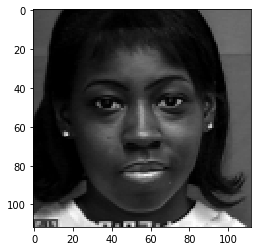

In [9]:
# Get this round's inspirational photo...
for image_features in parsed_train.take(1):
    image_raw = image_features['imageExpressive'].numpy()
    plt.imshow(np.squeeze(image_raw[0,:,:,:]), cmap='gray', vmin=-1, vmax=1)
    plt.show()

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim), # no activation...
        ], name="encoder")

    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

In [0]:
class Generator(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.generator = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),

            tf.keras.layers.Dense(units=7*7*256),
            tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False,
                activation="tanh"),
        ], name="generator")

    
    @tf.function
    def sample(self, epsilon=None):
        if epsilon is None:
            epsilon = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(epsilon, apply_sigmoid=True)
    
    @tf.function
    def reparameterize(self, mean, logvar):
        # Logvar used for numerical stability
        epsilon = tf.random.normal(shape=mean.shape)
        return epsilon * tf.exp(logvar * .5) + mean

    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.generator(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    
    @tf.function
    def generateDist(self, mean, logvar):
        z = self.reparameterize(mean, logvar)
        return self.generateZ(z)

    @tf.function
    def generateZ(self, z):
        x_logit = self.decode(z)
        return x_logit


In [0]:
@tf.function
def generateImg(x):
    mean, logvar = encoder.encode(x)
    return generator.generateDist(mean, logvar)

In [0]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Dense(1, activation='sigmoid'),
        ], name="discriminator")
    
    @tf.function
    def decide(self, x):
        return self.discriminator(x)


In [0]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam( learning_rate=0.0001, beta_1=0.5)

latent_dim = 100
prior = tfp.distributions.MultivariateNormalDiag(tf.zeros(latent_dim), tf.ones(latent_dim))
alpha = tf.convert_to_tensor(0.2, dtype=tf.float32)

@tf.function
def compute_apply_gradients(enc, gen, dis, x_neutral, x_express, x_other, encOptimizer, genOptimizer, disOptimizer, beta):
    # Watch any trainable variables for automatic differentiation
    with tf.GradientTape(persistent=True) as tape:
        enc_loss, gen_loss, dis_loss = compute_loss(enc, gen, dis, x_neutral, x_express, x_other, beta)

    gradients_of_encoder = tape.gradient(enc_loss, enc.trainable_variables)
    gradients_of_generator = tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = tape.gradient(dis_loss, dis.trainable_variables)

    encOptimizer.apply_gradients(zip(gradients_of_encoder, enc.trainable_variables))
    genOptimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    disOptimizer.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))


@tf.function
def compute_apply_gradients_separately(enc, gen, dis, x_neutral, x_express, x_other, encOptimizer, genOptimizer, disOptimizer, beta):
    # Watch any trainable variables for automatic differentiation
    with tf.GradientTape() as tape:
        # Triplet Loss
        mean_e, logvar_e = enc.encode(x_express)
        mean_n, logvar_n = enc.encode(x_neutral)
        mean_o, logvar_o = enc.encode(x_other)
        triplet = triplet_loss(mean_n, mean_e, mean_o, alpha)

        # KL Divergence loss
        posterior = tfp.distributions.MultivariateNormalDiag(mean_e, logvar_e)
        divergence = tfp.distributions.kl_divergence(posterior, prior)

        enc_loss = triplet + (beta * divergence)

    gradients_of_encoder = tape.gradient(enc_loss, enc.trainable_variables)
    encOptimizer.apply_gradients(zip(gradients_of_encoder, enc.trainable_variables))

    with tf.GradientTape() as eTape, tf.GradientTape() as gTape:
        mean_e, logvar_e = enc.encode(x_express)
        if beta < 0.5:
            # Just be an auto-encoder to warm up
            output_images = gen.generateZ(mean_e)
        else:
            # Now let's get variational up in here
            output_images = gen.generateDist(mean_e, logvar_e)
        
        output_decisions = dis.decide(output_images)

        gen_loss = generator_loss(output_images, output_decisions, mean_e, logvar_e, enc)

    
    gradients_of_generator = gTape.gradient(gen_loss, gen.trainable_variables)
    genOptimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

    with tf.GradientTape() as tape:
        real_decisions = dis.decide(x_neutral)
        fake_decisions = dis.decide(output_images)

        dis_loss = discriminator_loss(real_decisions, fake_decisions)

    gradients_of_discriminator = tape.gradient(dis_loss, dis.trainable_variables)
    disOptimizer.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))


    

@tf.function
def compute_loss(enc, gen, dis, x_neutral, x_express, x_other, beta):
    mean_e, logvar_e = enc.encode(x_express)
    if beta < 0.5:
        # Just be an auto-encoder to warm up
        generated_images = gen.generateZ(mean_e)
    else:
        # Now let's get variational up in here
        generated_images = gen.generateDist(mean_e, logvar_e)
    
    # Let the discriminator discriminate
    real_decisions = dis.decide(x_neutral)
    fake_decisions = dis.decide(generated_images)

    # Compute all the losses
    dis_loss = discriminator_loss(real_decisions, fake_decisions)
    gen_loss = generator_loss(generated_images, fake_decisions, mean_e, logvar_e, enc)
    enc_loss = encoder_loss(enc, x_neutral, mean_e, logvar_e, x_other, beta)
    return enc_loss, gen_loss, dis_loss


@tf.function
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    
    # Loss from failing to identify real images
    real_labels = tf.ones_like(real_output)# - tf.random.uniform(real_output.shape, minval=0, maxval=0.2)
    real_loss = cross_entropy(real_labels, real_output)
    
    # Loss from failing to identify fake images
    fake_labels = tf.zeros_like(fake_output)# + tf.random.uniform(fake_output.shape, minval=0, maxval=0.2)
    fake_loss = cross_entropy(fake_labels, fake_output)
    
    return real_loss + fake_loss


@tf.function
def generator_loss(output_images, output_decisions, mean_e, logvar_e, enc):
    # Loss from not preserving identity
    mean_out, logvar_out = enc.encode(output_images)
    mse = tf.keras.losses.MeanSquaredError()
    identityDiff = mse(mean_e, mean_out)

    # Loss from not fooling the discriminator
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    detections = cross_entropy(tf.ones_like(output_decisions), output_decisions)

    return identityDiff + detections

@tf.function
def encoder_loss(enc, x_neutral, mean_e, logvar_e, x_other, beta):
    # Triplet Loss
    mean_n, logvar_n = enc.encode(x_neutral)
    mean_o, logvar_o = enc.encode(x_other)
    triplet = triplet_loss(mean_n, mean_e, mean_o, alpha)

    # KL Divergence loss
    posterior = tfp.distributions.MultivariateNormalDiag(mean_e, logvar_e)
    divergence = tfp.distributions.kl_divergence(posterior, prior)

    return triplet + (beta * divergence)

@tf.function
def triplet_loss(anchor, positive, negative, alpha):
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.subtract(anchor,positive),1)
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.subtract(anchor,negative),1)

    tl = tf.math.maximum(pos_dist - neg_dist + alpha, 0)
    return tl

In [0]:
epochs = 200
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction)
# so it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

random_images_for_generation = [image_features['imageExpressive'] for image_features in parsed_test.take(1)][0][0:num_examples_to_generate]

encoder = Encoder(100)
generator = Generator(100)
discriminator = Discriminator()

In [0]:
# setup checkpoint stuff
checkpoint_dir = BASE_DIR + 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(encoder_optimizer=encoder_optimizer,
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 encoder=encoder,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
def save_images(epoch, test_input):
    imgs = generator.sample(test_input)
    assert not np.any(np.isnan(imgs))
    fig = plt.figure(figsize=(4,4))
    ds = discriminator.decide(imgs)
    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.gca().set_title("{0:.4f}".format(ds[i,0]))
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)

def display_discrim_images(imgs, dis):
    fig = plt.figure(figsize=(4,4))
    ds = discriminator.decide(imgs)
    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.gca().set_title("{0:.4f}".format(ds[i,0]))
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.show()

def display_imgs_ratings(test_input, data, noise_intensity, epoch=-1):
    images = generateImg(test_input[0:8])
    noise = np.random.normal(0, 1, images.shape).astype('float32')
    for features in data:
        expressive = features['imageExpressive']
        neutral = features['imageNeutral'] + np.random.normal(0, noise_intensity, expressive.shape)
    ims = np.concatenate((test_input[0:8], images, neutral[0:8], expressive[0:8]), axis=0)
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(9,5))
    ds = discriminator.decide(ims)
    for i in range(ims.shape[0]):
        r = i % 8
        c = i // 8
        axes[c, r].set_title("{0:.6f}".format(ds[i,0]))
        axes[c, r].imshow(ims[i, :, :, 0], cmap='gray')
        axes[c, r].set_yticklabels([])
        axes[c, r].xaxis.set_visible(False)
    axes[0,0].set_ylabel("Inputs", size='large')
    axes[1,0].set_ylabel("Generated", size='large')
    axes[2,0].set_ylabel("Neutral*", size='large')
    axes[3,0].set_ylabel("Expressive", size='large')
    fig.tight_layout()
    if epoch >= 0:
        plt.savefig('gens_ratings_at_epoch_{:04d}.png'.format(epoch))
        plt.close(fig)
    else:
        plt.show()

def plot_ELBOs(es):
    fig = plt.figure()
    plt.plot(es)
    plt.ylabel('ELBO')
    plt.xlabel('Epoch')
    plt.show()

def plot_GAN_loss(ls):
    el, gl, dl = zip(*ls)
    fig = plt.figure()
    plt.plot(el, 'b', label='Le')
    plt.plot(gl, 'g', label='Lg')
    plt.plot(dl, 'r', label='Ld')
    plt.title("Encoder (Le), Generator (Lg), and Discriminator (Ld) Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

Epoch 40, Test set eloss 0.20132309198379517, gloss 5.521007061004639, dloss 0.040328532457351685, time elapsed for current epoch 45.0
Noise intensity: 0		Beta: 1.0


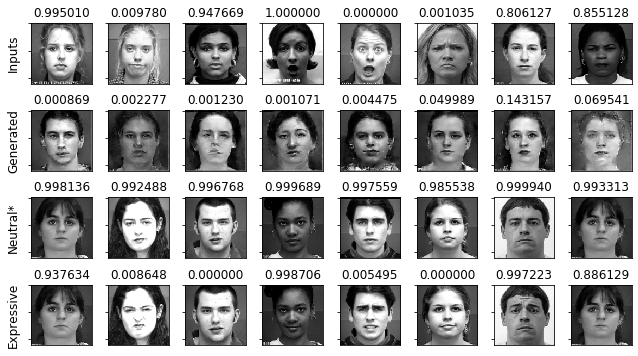

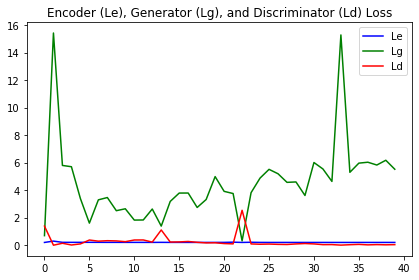

..........

In [0]:
# Save image for pre-training
noise_intensity = max_noise_intensity = 0#0.5
max_beta = 1
beta = 0
ramp_end = 10

# Test
eloss = tf.keras.metrics.Mean()
gloss = tf.keras.metrics.Mean()
dloss = tf.keras.metrics.Mean()
for image_features in parsed_test:
    el, gl, dl = compute_loss(encoder, generator, discriminator,
                          image_features['imageNeutral'], image_features['imageExpressive'], image_features['imageOther'],
                          0)
    eloss(el)
    gloss(gl)
    dloss(dl)
el = eloss.result()
gl = gloss.result()
dl = dloss.result()
ls = [(el, gl, dl)]

start_time = end_time = 0
for epoch in range(1, epochs+1):
    print('Epoch {0}, Test set eloss {1}, gloss {2}, dloss {3}, '
        'time elapsed for current epoch {4:.1f}'.format(
            epoch, el, gl, dl, end_time - start_time))
    print("Noise intensity: {0}\t\tBeta: {1}".format(noise_intensity, beta))
    display_imgs_ratings(random_images_for_generation, parsed_test.take(1), noise_intensity)    
    save_images(epoch, random_vector_for_generation)
    plot_GAN_loss(ls)

    # Train
    start_time = time.time()
    batchCounter = 0
    noise_intensity = max(0, max_noise_intensity * (1 - (epoch / ramp_end)))
    beta = min(max_beta, max_beta * (epoch / ramp_end))
    beta = tf.convert_to_tensor(beta, dtype=tf.float32)
    for image_features in parsed_train:
        neutral_raw = image_features['imageNeutral']
        neutral_raw = neutral_raw + np.random.normal(0, noise_intensity, neutral_raw.shape)
        assert not np.any(np.isnan(neutral_raw))
        expressive_raw = image_features['imageExpressive']
        assert not np.any(np.isnan(expressive_raw))
        other_raw = image_features['imageOther']
        assert not np.any(np.isnan(other_raw))

        compute_apply_gradients_separately(
            encoder, generator, discriminator,
            neutral_raw, expressive_raw, other_raw,
            encoder_optimizer, generator_optimizer, discriminator_optimizer,
            beta)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")
    end_time = time.time()
    
    # Test
    eloss = tf.keras.metrics.Mean()
    gloss = tf.keras.metrics.Mean()
    dloss = tf.keras.metrics.Mean()
    for image_features in parsed_test:
        neutral_raw = image_features['imageNeutral']
        expressive_raw = image_features['imageExpressive']
        other_raw = image_features['imageOther']

        el, gl, dl = compute_loss(encoder, generator, discriminator,
                                  neutral_raw, expressive_raw, other_raw,
                                  beta)
        eloss(el)
        gloss(gl)
        dloss(dl)
    el = eloss.result()
    gl = gloss.result()
    dl = dloss.result()
    ls = ls + [(el, gl, dl)]
    
    display.clear_output(wait=False)

    # Save the model from time to time
    if (epoch + 1) % 20 == 0:
        display_imgs_ratings(random_images_for_generation, parsed_test.take(1), noise_intensity, epoch)
        checkpoint.save(file_prefix = checkpoint_prefix)

    tf.keras.backend.clear_session()

In [0]:
checkpoint_prefix = os.path.join(checkpoint_dir, "FINAL_CKPT_" + time.strftime('%l:%M%b%d'))
checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
anim_filename = "/content/drive/My Drive/StoicNetData/TrainingGifs/vaegan" + time.strftime('%l:%M %b %d') + ".gif"
print(anim_filename)
with imageio.get_writer(anim_filename, mode='I') as writer:
    filenames = glob.glob('image_at_epoch_*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [0]:
plot_GAN_loss(ls)